# 20. scikit-learn

scikit-learn is the most popular Machine Learning package in Python. It implements many different types of models, regression, trees, clustering etc. as well as many useful tools for pre- and post-processing. Just like for scipy and statsmodels, we give here an extremely brief introduction to this library, rather to explain its general functioning than to present specific methods. Note that scikit-learn only offers "classical" methods and cannot be used e.g. for Deep Learning.

## Linear regression

As a start we will once again look at linear regression. As we have seen this method via the precedent packages, it represents a good opportunity to understand the general mechanism of the library. Let's first import the diamond data:

In [23]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

diams = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/Ecdat/Diamond.csv', index_col=0)

Now we can import the scikit-learn module implementing linear models with:

In [2]:
from sklearn import linear_model

The module offers a very [extensive list](https://scikit-learn.org/stable/modules/classes.html#classical-linear-regressors) of regression models for almost any situation including e.g. outlier, feature selection etc. Here we first use a simple linear regressor. We first instantiate it:

In [10]:
model = linear_model.LinearRegression()

And like in statsmodels we can now ```fit``` our data. For this we have again to pass our indpendent and dependent variables as Numpy arrays (one row per element in the dataset, one column per feature). Here we only use again price and carat. As we could pass multiple features (not just carat), the ```fit``` function expects a 2D array for X:

In [13]:
X = diams.carat.values
X = X[:,np.newaxis]
X.shape

(308, 1)

In [18]:
res = model.fit(X=X, y=diams.price)

Also here ```res``` is an object that contains all the necessary information about our fit. For example we can recover the intercept and fit coefficient:

In [21]:
res.intercept_

-2298.357601893803

In [22]:
res.coef_

array([11598.88401288])

We can also use the ```predict``` function on new values for the price. We use it here to display the fit:

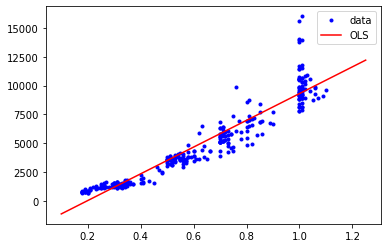

In [26]:
plt.plot(diams.carat, diams.price, "b.", label="data")
plt.plot(np.linspace(0.1,1.25,10), res.predict(np.linspace(0.1,1.25,10)[:,np.newaxis]), "r-", label="OLS")
plt.legend();


As before, we can consider a more complex models by adding higher terms (quadratic etc.). We could do it "manually" by adding those features to ```X``` but scikit-learn offers some help for this. We can use the ```PolynomialFeatures``` class for that:

In [30]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_2 = poly.fit_transform(X)

In [31]:
X_2.shape

(308, 3)

In [32]:
X_2[0:5,:]

array([[1.    , 0.3   , 0.09  ],
       [1.    , 0.3   , 0.09  ],
       [1.    , 0.3   , 0.09  ],
       [1.    , 0.3   , 0.09  ],
       [1.    , 0.31  , 0.0961]])

We see now that we have turned our single parameter into three (including the intercept). We can now again fit and display. Note that here again the ```predict``` input should also be passed through the ```fit_transform``` function to match the dimensions of the training data:

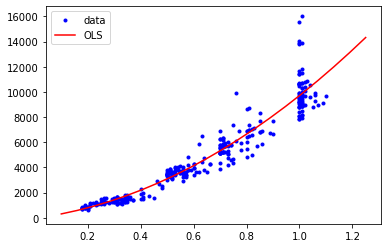

In [39]:
res = model.fit(X=X_2, y=diams.price)

plt.plot(diams.carat, diams.price, "b.", label="data")
plt.plot(np.linspace(0.1,1.25,20), res.predict(poly.fit_transform(np.linspace(0.1,1.25,20)[:,np.newaxis])), "r-", label="OLS")
plt.legend();


### SGD

We show now one alternative model for linear regression, just to highlight the fact the despite using very different algorithms, they are used almost in the same way in scikit-learn. We use here Stochastic Gradient Descent, which can be useful for large high-dimensional datasets where OLS would be very slow. Let's define our regressor:

In [40]:
model = linear_model.SGDRegressor()

And now we use it just like done above. As you can see, the **only** thing that changes is the model definition. All the rest, with the ```fit``` and ```predict``` methods remains unchanged! This makes it very easy to explore many models to find the best one for your problem.

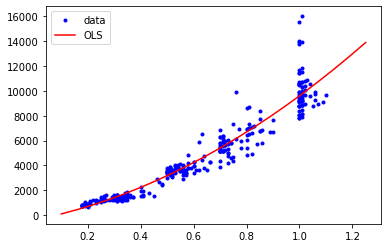

In [43]:
res = model.fit(X=X_2, y=diams.price)

plt.plot(diams.carat, diams.price, "b.", label="data")
plt.plot(np.linspace(0.1,1.25,20), res.predict(poly.fit_transform(np.linspace(0.1,1.25,20)[:,np.newaxis])), "r-", label="OLS")
plt.legend();


## Classification

A big strength of scikit-learn is its vast collection of classification methods. In contrast to regression where a continuous value is predicted from a set of features, classification attempts to assign data to *discrete* categories. 

For example we can split the diamonds into "expensive" and "cheap" categories and then try to classify them using the carat:

In [73]:
diams['price_cat'] = diams.price.apply(lambda x: 1 if x > 4000 else 0)

In [74]:
diams.head()

,carat,colour,clarity,certification,price,price_cat
1,0.30,D,VS2,GIA,1302,0
2,0.30,E,VS1,GIA,1510,0
3,0.30,G,VVS1,GIA,1510,0
4,0.30,G,VS1,GIA,1260,0
5,0.31,D,VS1,GIA,1641,0


We obtain now a plot that can definitely not be modelled via simple linear regression. The goal is to estimate where the boundary is between cheap and expensive:

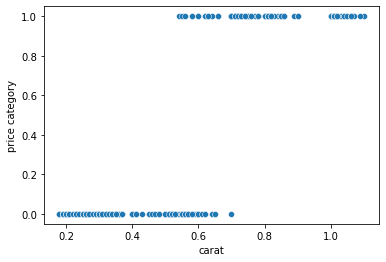

In [104]:
sns.scatterplot(data = {'carat': diams.carat, 'price category': diams.price_cat},
                x='carat', y='price category');

To find this boundary we can use logistic regression, which fits a sigmoid to the data. Again this is available from the ```linear_model``` module

In [105]:
from sklearn.linear_model import LogisticRegression

We feed the fit method exactly as before: we need an ```X``` array (or dataframe) of features and a ```y``` vector of targets:

In [106]:
model = LogisticRegression()
model.fit(X=diams[['carat']], y=diams.price_cat)

pred = model.predict(pd.DataFrame({'carat': np.arange(0,1,0.1)}))

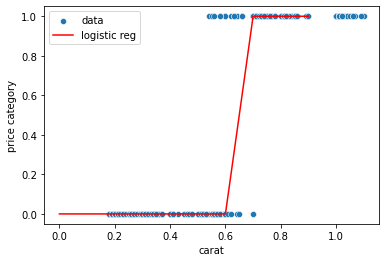

In [107]:
sns.scatterplot(data = {'carat': diams.carat, 'price category': diams.price_cat},
                x='carat', y='price category', label='data');
sns.lineplot(x=np.arange(0,1,0.1), y=pred, label='logistic reg', color='r');

Another large class of methods are tree based: you use all the features and by answering binary questions about them of the type "is feature large than a threshold" you can create a question-tree that in the end answers in which category a certain item falls. For example we can now try to use both the carat and the color to predict price. Here we have however one problem: these methods work only with numerical variable but the color is categorical. So we have to turn that variable into numbers, but we can't just assign numbers: if we do, suddenly a given color has a large or small value that doesn't make any sense but will impact the classification. The common solution is to use *one hot encoding* in this case: we create one new column for each colour and fill it with zeros and ones. Ones will only appear on those lines where the colour is actually appearing. Both Pandas and scikit-learn offer tools for that. In scikit-learn we use the ```OneHotEncoder``` from the ```preprocessing``` module

In [108]:
from sklearn import preprocessing

In [109]:
encoder = preprocessing.OneHotEncoder(sparse=False)
encoder.fit_transform(diams[['colour']])

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [110]:
diams.colour.head(5)

1    D
2    E
3    G
4    G
5    D
Name: colour, dtype: object

Here we see how the encoding works: the first column corresponds to the colour ```D```. As the first item is D, we have a ```1``` there and zeros for all other columns. The second item has colour ```E``` which is encoded in the second column. So we have a ```1``` in the second column and zeros in all others etc.

The ```get_dummies``` function in Pandas allows us to do the same operation but here we get a DataFrame as output: 

In [111]:
color_one_hot = pd.get_dummies(diams.colour, prefix='colour')
color_one_hot.head(5)

,colour_D,colour_E,colour_F,colour_G,colour_H,colour_I
1,1,0,0,0,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0
5,1,0,0,0,0,0


Now we can combine the carat information with this new colour dataframe to create our variable ```X```:

In [113]:
X = pd.concat([diams[['carat']], color_one_hot], axis=1)
X.head(5)

,carat,colour_D,colour_E,colour_F,colour_G,colour_H,colour_I
1,0.30,1,0,0,0,0,0
2,0.30,0,1,0,0,0,0
3,0.30,0,0,0,1,0,0
4,0.30,0,0,0,1,0,0
5,0.31,1,0,0,0,0,0


Finally, we can create a decision tree. Again, we use it by feeding an ```X``` array and ```y``` vector:

In [114]:
from sklearn import tree

y = diams.price_cat
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X, y)

We can visualize the decision tree:

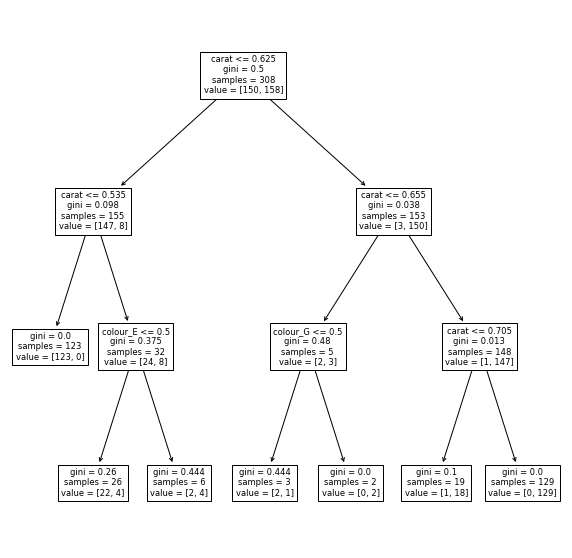

In [116]:
fig, ax = plt.subplots(figsize=(10,10))
tree.plot_tree(clf, feature_names=X.columns, ax=ax);

We limited the tree to three levels. We could add more and have a better classification, but the risk is to overfit. In this tree we see that the most important feature is the ```carat``` which does the first split at a value of 0.625. Then some minor improvement is added by using the colours ```E``` and ```G``` in two places.

## Clustering

The last important category of operation we can do with scikit-learn is clustering. Here the goal is to split data in multiple groups without knowing in advance the groups. For example we can try to define cluster of points in the price vs. carat plot:

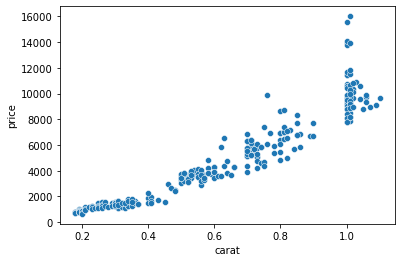

In [118]:
sns.scatterplot(data=diams, x='carat', y='price');

We will show a simple example using k-means clustering from the ```cluster``` module:

In [119]:
from sklearn import cluster

In [388]:
cls = cluster.KMeans(n_clusters=3)
X = diams[['carat', 'price']]
cls.fit(X=X)

KMeans(n_clusters=3)

Now we can visualy verify the result. First we add the classification label to our table to be use it to colour points. We specify it has a categorical variable so that seaborn then uses an appropriate colour palette:

In [389]:
X['label'] = pd.Categorical(cls.labels_)

/var/folders/mk/632_7fgs4v374qc935pvf9v00000gn/T/ipykernel_70861/2577989311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['label'] = pd.Categorical(cls.labels_)


In [390]:
X.head(5)

,carat,price,label
1,0.30,1302,2
2,0.30,1510,2
3,0.30,1510,2
4,0.30,1260,2
5,0.31,1641,2


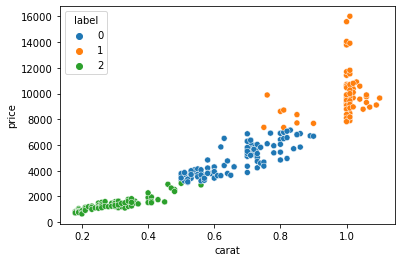

In [391]:
sns.scatterplot(data=X, x='carat', y='price', hue='label');

## Other tools

scikit-learn also offers many additional tools useful in ML and we only highlight a few of them here. 

### Normalizing data

Certain ML models require the variables to be normalized or scaled. For example in clustering, if the metric used is simply the distance between points, the feature with the largest magnitude will dominate and to avoid that, one should normalize each feature first. All normalizers can be found in the ```preprocessing``` module and are essentially used like the models:

In [438]:
from sklearn import preprocessing

In [441]:
X = diams[['carat', 'price']]

scaler = preprocessing.StandardScaler()

X_norm = scaler.fit_transform(X=X)
X_norm = pd.DataFrame(X_norm, columns=X.columns)

In [442]:
cls = cluster.KMeans(n_clusters=3)
cls.fit(X=X_norm)

X_norm['label'] = pd.Categorical(cls.labels_)

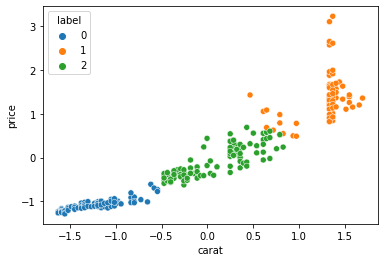

In [443]:
sns.scatterplot(data=X_norm, x='carat', y='price', hue='label');

### Metrics

Another very important module contains a large choice of metrics read to use. For example instead of manually computing the mean squared error we can use:

In [445]:
res = model.fit(X=X, y=diams.price)

In [446]:
y_pred = res.predict(X)

In [447]:
from sklearn import metrics

In [453]:
y_pred.shape

(308,)

In [455]:
metrics.mean_squared_error(diams.price, y_pred)

7153388.292207792

For classification we can use for example the accuracy:

In [456]:
model = LogisticRegression()
model.fit(X=diams[['carat']], y=diams.price_cat)

pred = model.predict(diams[['carat']])#pd.DataFrame({'carat': np.arange(0,1,0.1)}))

In [460]:
metrics.accuracy_score(y_true=diams.price_cat, y_pred=pred)

0.9642857142857143

### Pipelines

Finally we can incorporate multiple parts of our process into a single pipeline. For example if we need to first normalize and then cluster data, we can add both process into a single pipeline:

In [461]:
from sklearn.pipeline import Pipeline

In [463]:
pipe = Pipeline([('normalize', preprocessing.StandardScaler()), ('cluster', cluster.KMeans(n_clusters=3))])

In [464]:
pipe.fit(X)

Pipeline(steps=[('normalize', StandardScaler()),
                ('cluster', KMeans(n_clusters=3))])

In [465]:
pipe.named_steps['cluster'].labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

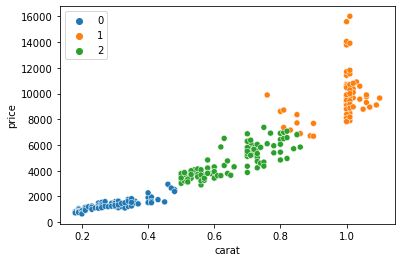

In [468]:
sns.scatterplot(data=X, x='carat', y='price', hue=pd.Categorical(pipe.named_steps['cluster'].labels_));

## Exercise

1. In the penguins dataset, do a linear regression between the ```flipper_length_mm``` and ```body_mass_g``` features and plot the result. You might run into an error: carefully read the error and try to fix the problem.

In [193]:
import pandas as pd
penguins = pd.read_csv('https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv')

2. Do again a linear regression but this time add a polynomial feature (e.g. 2)

3. Subselect the Gentoo species and run a logistic regression to classify penguins as male/female based on the ```body_mass_g``` feature. Use the ```liblinear``` solver option.

4. Try to cluster the ```flipper_length_mm``` vs ```bill_length_mm``` features using ```SpectralClustering``` with 3 clusters. Do the cluster first without then with applying the standard scaler to the input